---
# pRF spread across runs (2D-EPI data)

In [8]:
%matplotlib inline

In [2]:
from linescanning import (
    utils,
    plotting,
    prf,
    fitting
)

import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from PIL import ImageColor
opj = os.path.join

221004-10:02:27,734 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.8.2


In [56]:
sub = "003b"

data_dir = f"/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-{sub}/ses-1/unzscored"
data_files = utils.get_file_from_substring("npy", data_dir, exclude="hemi-R")
design = utils.resample2d(prf.read_par_file(f"/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/prf/sub-{sub}/ses-1/design_task-2R.mat"), new_size=100)

print(data_files)
print(f"design: {design.shape}")

['/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-003b/ses-1/unzscored/sub-003b_ses-1_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy', '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-003b/ses-1/unzscored/sub-003b_ses-1_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy', '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-003b/ses-1/unzscored/sub-003b_ses-1_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy', '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-003b/ses-1/unzscored/sub-003b_ses-1_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy', '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-003b/ses-1/unzscored/sub-003b_ses-1_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy', '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pybest/sub-003b/ses-1/unzscored/sub-003b_ses-1_task-2R_run-6_space-fsnative_hemi-L_desc

In [43]:
fits = {}
for ix,data in enumerate(data_files):
    
    # get target vertex data
    vox_data = np.load(data)[:,646][np.newaxis,:]

    # convert to percent change
    vox_psc = utils.percent_change(vox_data, 1, baseline=25)

    # fit
    fit_ = prf.pRFmodelFitting(
        vox_psc,
        design_matrix=design,
        fix_bold_baseline=True,
        model="norm",
        verbose=False,
        rsq_threshold=0
    )

    fit_.fit()
    fits[ix] = fit_

In [44]:
for key in list(fits.keys()):
    if key != "avg":
        print(f"run-{key+1}; r2={fits[key].gauss_iter[0,-1]}")

run-1; r2=0.5701688102436188
run-2; r2=0.47407746567481535
run-3; r2=0.3155794180042937
run-4; r2=0.364153139829806
run-5; r2=0.37192006256945165
run-6; r2=0.32679011511756295


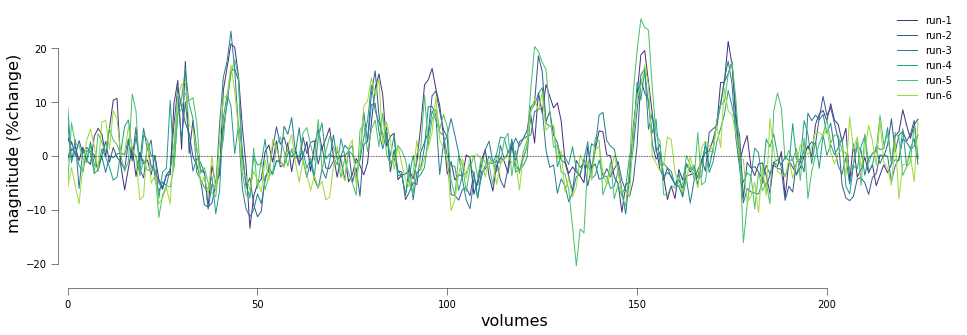

In [54]:
plotting.LazyPlot(
    [fits[key].data.T for key in list(fits.keys()) if key != "avg"],
    figsize=(16,5),
    labels=[f"run-{key+1}" for key in list(fits.keys()) if key != "avg"],
    x_label="volumes",
    y_label="magnitude (%change)",
    font_size=16,
    add_hline=0
)

In [45]:
avg = np.vstack([np.load(ii)[:,646][np.newaxis,:] for ii in data_files]).mean(axis=0)[np.newaxis,:]
avg_psc = utils.percent_change(avg, 1, baseline=25)
avg_psc.shape

(1, 225)

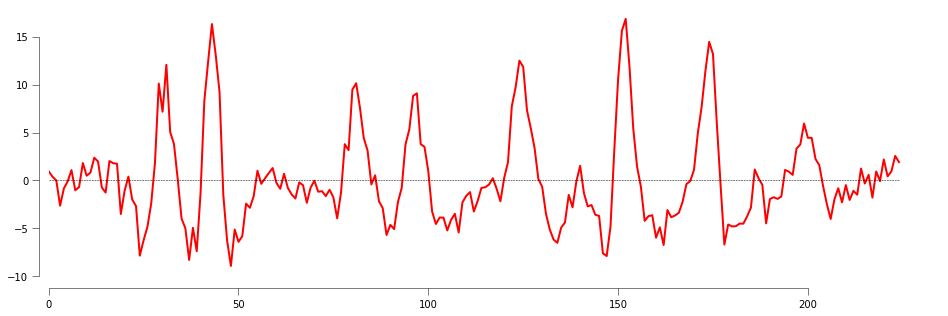

In [46]:
plotting.LazyPlot(
    avg_psc.T, 
    # add_vline=pkz, 
    color="r", 
    figsize=(16,5), 
    line_width=2,
    add_hline='default')

In [47]:
# fg = fine grid
avg_ = prf.pRFmodelFitting(
    avg_psc,
    design_matrix=design,
    fix_bold_baseline=True,
    model="norm",
    rsq_threshold=0,
    verbose=True
)

avg_.fit()
fits['avg'] = avg_

Reading settings from '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/code/prf_analysis.yml'
Fixing baseline at [0, 0]
Instantiate HRF with: [1, 1, 0]
Setting 'rsq_threshold' to user-defined value: 0 (was: 0.1)
Starting gauss grid fit at 2022/10/04 14:37:28
Completed Gaussian gridfit at 2022/10/04 14:37:32. Voxels/vertices above 0: 1/1
Gridfit took 0:00:03.557176
Mean rsq>0: 0.51
Starting gauss iterfit at 2022/10/04 14:37:32
Completed gauss iterfit at 2022/10/04 14:37:32. Mean rsq>0: 0.52
Iterfit took 0:00:00.751944
Reading settings from '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/code/prf_analysis.yml'
Starting norm gridfit at 2022/10/04 14:37:32
Completed norm gridfit at 2022/10/04 14:37:33. Mean rsq>0.1: 0.61
Gridfit took 0:00:00.336669
Starting norm iterfit at 2022/10/04 14:37:33
Completed norm iterfit at 2022/10/04 14:37:48. Mean rsq>0.1: 0.64
Iterfit took 0:00:15.422775


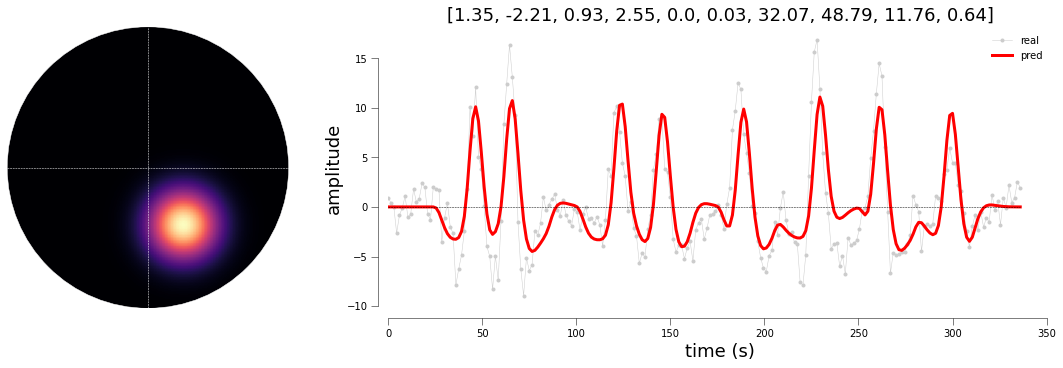

In [50]:
_,_,_,_ = avg_.plot_vox(
    model="norm", 
    stage="iter", 
    title="pars", 
    axis_type="time")

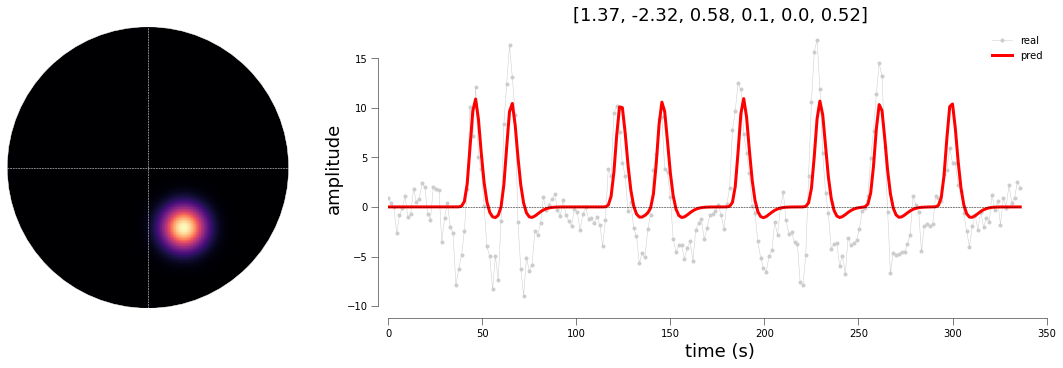

In [51]:
_,_,_,_ = avg_.plot_vox(
    model="gauss", 
    stage="iter", 
    title="pars", 
    axis_type="time")

In [53]:
fits2 = fits.copy()
# fits2.pop(5)
fits2

{0: <linescanning.prf.pRFmodelFitting at 0x7f82c6825e80>,
 1: <linescanning.prf.pRFmodelFitting at 0x7f82bd9bcfa0>,
 2: <linescanning.prf.pRFmodelFitting at 0x7f82c116e250>,
 3: <linescanning.prf.pRFmodelFitting at 0x7f82c446d4f0>,
 4: <linescanning.prf.pRFmodelFitting at 0x7f82be218070>,
 5: <linescanning.prf.pRFmodelFitting at 0x7f82c11e9e80>,
 'avg': <linescanning.prf.pRFmodelFitting at 0x7f82c10be880>}

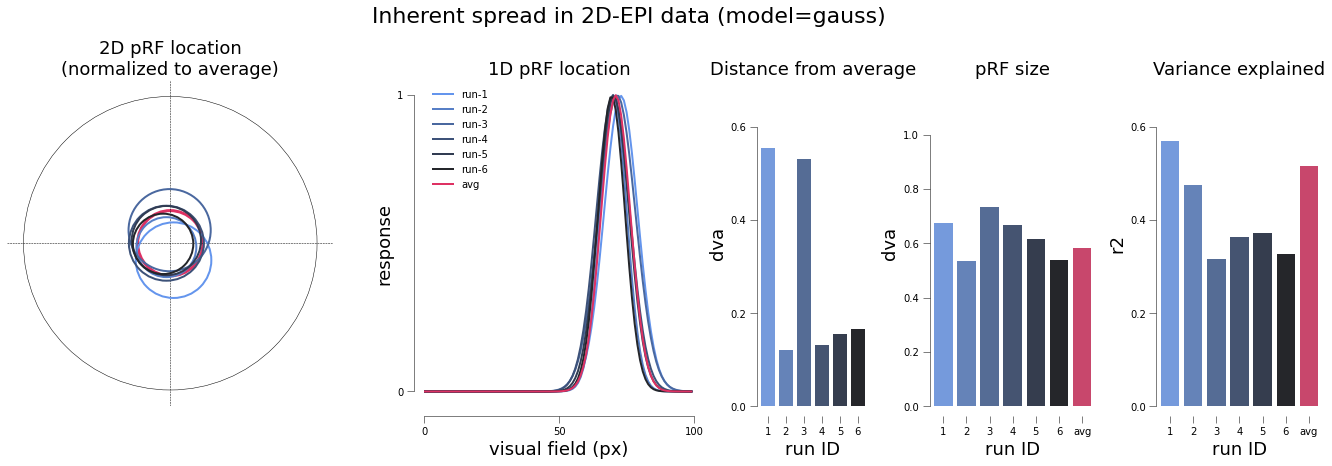

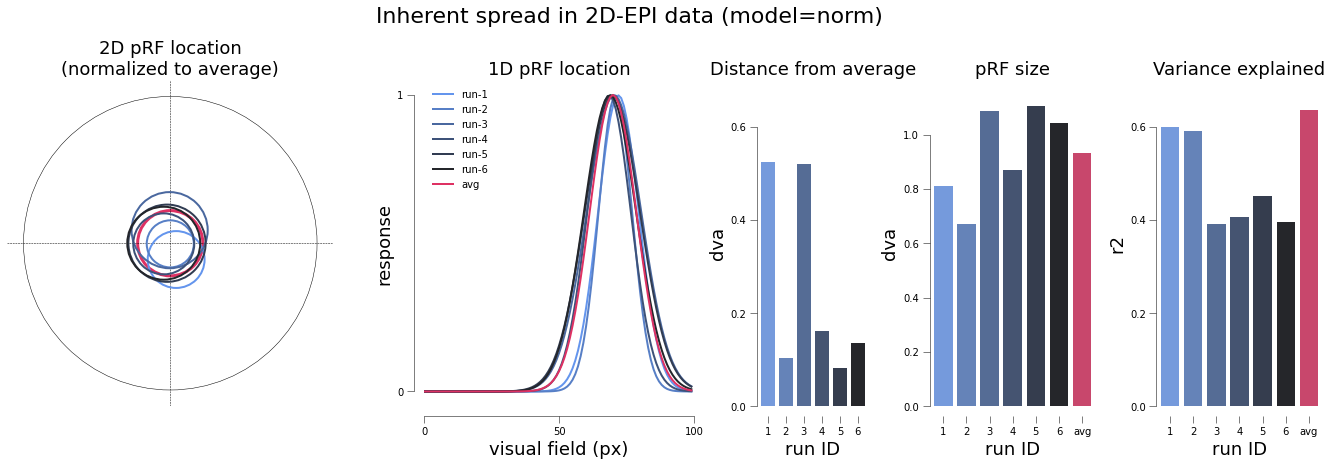

In [58]:
for model in ["gauss", "norm"]:

    fig = plt.figure(figsize=(24,6))
    gs = fig.add_gridspec(1,5, width_ratios=(35,25,10,15,15), wspace=0.3)

    colors = ["#DE3163", "#6495ED"]
    cmap1 = utils.make_binary_cm(colors[0])
    cmap2 = utils.make_binary_cm(colors[1])

    color_p = sns.color_palette(sns.color_palette(f"light:{colors[1]}", len(fits2)-1))
    color_p = sns.dark_palette(colors[1], len(fits2)-1, reverse=True)
    color_p += [tuple([ii/255 for ii in ImageColor.getcolor(colors[0], "RGB")])]

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])
    ax4 = fig.add_subplot(gs[3])
    ax5 = fig.add_subplot(gs[4])

    dist = []
    for ii in fits2:

        if ii != "avg":

            # get parameters from individual runs
            pars,prf_r,_,_ = fits2[ii].plot_vox(
                model=model,
                stage='iter',
                make_figure=False
            )
        
            # get parameters from average
            avg_pars,avg_r,_,_ = fits2['avg'].plot_vox(
                model=model,
                stage='iter',
                make_figure=False
            )

            # make prf object of average
            avg_prf = prf.make_prf(
                fits2['avg'].prf_stim, 
                mu_x=0,
                mu_y=0,
                size=1,
                resize_pix=500
            )

            # plot
            if ii == 0:
                prf1 = np.zeros_like(avg_prf)

                # create circle object
                circ = plt.Circle(
                    (0,0),
                    1,
                    fill=False,
                    ec=colors[0],
                    lw=3)

                ax1.set_aspect(1)
                ax1.add_artist(circ)

                # create visual field delineation
                plotting.LazyPRF(
                    prf1, 
                    [-5,5],
                    ax=ax1,
                    cmap=cmap1,
                    cross_color="k",
                    shrink_factor=0.9,
                    title="2D pRF location\n(normalized to average)",
                    vf_only=True,
                    font_size=18,
                    alpha=0.8)

                # get 1d profile
                max_idx = np.where(avg_r == np.amax(avg_r))[1]
                avg_1d = avg_r[:,max_idx]

            # plot normalized pRF
            run_pars = prf.normalize_prf(avg_pars,pars)
            run_prf = prf.make_prf(
                fits2[ii].prf_stim, 
                mu_x=run_pars[0],
                mu_y=run_pars[1],
                size=run_pars[2],
                resize_pix=500
            )
            
            # find x/y of max pRF
            x,y = np.where(run_prf == np.amax(run_prf))
            center = np.array([x[0],y[0]])

            # convert pixels to whatever visual field is
            center = tuple(center/run_prf.shape[0]*10-5)
            prf2 = np.zeros_like(run_prf)

            circ2 = plt.Circle(
                center,
                run_pars[2],
                fill=False,
                ec=color_p[ii],
                lw=2)

            # ax1.set_aspect(1)
            ax1.add_artist(circ2)

            # get 1d profile
            max_idx = np.where(prf_r == np.amax(prf_r))[1]
            run_1d = prf_r[:,max_idx]

            plotting.LazyPlot(
                run_1d,
                axs=ax2,
                line_width=2,
                color=color_p[ii]
            )

            # get euclidian distance between average pRF and run-pRF
            dist.append(prf.distance_centers(avg_pars, pars))

    plotting.LazyPlot(
        avg_1d,
        axs=ax2,
        line_width=2,
        color=colors[0],
        title="1D pRF location",
        font_size=18,
        y_ticks=[0,1],
        x_label="visual field (px)",
        y_label="response",
        x_lim=[0,design.shape[0]],
        x_ticks=[0,design.shape[0]//2,design.shape[0]]
    )

    ax2.legend([f"run-{ii+1}" if isinstance(ii,int) else ii for ii in list(fits2.keys())], frameon=False)

    # make plot with spread in dva
    dist = np.array(dist)
    plotting.LazyBar(
        x=[ii+1 for ii in list(fits2.keys()) if ii != "avg"],
        y=dist,
        palette=color_p,
        axs=ax3,
        sns_ori="v",
        lim=[0,.7],
        add_labels=True,
        x_label2="run ID",
        y_label2="dva",
        font_size=18,
        title2="Distance from average"
    )

    # make plot with size
    sizes = np.array([getattr(fits2[ii], f"{model}_iter")[:,2][0] for ii in fits2])
    size_colors = color_p+[tuple([ii/255 for ii in ImageColor.getcolor(colors[0], "RGB")])]
    plotting.LazyBar(
        x=[ii+1 if isinstance(ii,int) else ii for ii in list(fits2.keys())],
        y=sizes,
        palette=size_colors,
        axs=ax4,
        sns_ori="v",
        lim=[0,1.2],
        add_labels=True,
        x_label2="run ID",
        y_label2="dva",
        font_size=18,
        title2="pRF size"
    )        

    # make plot with r2
    r2 = np.array([getattr(fits2[ii], f"{model}_iter")[:,-1][0] for ii in fits2])
    plotting.LazyBar(
        x=[f"{ii+1}" if isinstance(ii,int) else ii for ii in list(fits2.keys())],
        y=r2,
        palette=size_colors,
        axs=ax5,
        sns_ori="v",
        lim=[0,.7],
        add_labels=True,
        x_label2="run ID",
        y_label2="r2",
        font_size=18,
        title2="Variance explained"
    )    

    fig.suptitle(f"Inherent spread in 2D-EPI data (model={model})", fontsize=22, y=1.05)

    fig.savefig(f"/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/prf/sub-007/whatsgoingon/sub-{sub}_model-{model}_desc-spread_2depi.svg", dpi=300, bbox_inches='tight', facecolor="white")

In [22]:
color_p

[(0.39215686274509803, 0.5843137254901961, 0.9294117647058824),
 (0.3288856569804768, 0.4747089609232512, 0.7385996183243364),
 (0.26561445121585553, 0.36510419635630625, 0.5477874719427904),
 (0.20234324545123428, 0.25549943178936135, 0.35697532556124445),
 (0.1400606522766852, 0.1476072416687749, 0.16914461896691013),
 (0.8705882352941177, 0.19215686274509805, 0.38823529411764707)]

In [65]:
avg_1d.shape

(100, 1)

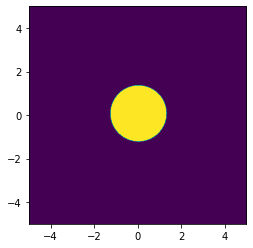

In [157]:
plt.imshow(prf2, extent=[-5,5]+[-5,5])

In [159]:
SR_ = prf.SizeResponse(avg_.prf_stim, avg_.norm_iter)

In [166]:
SR_.make_stimuli(factor=2)

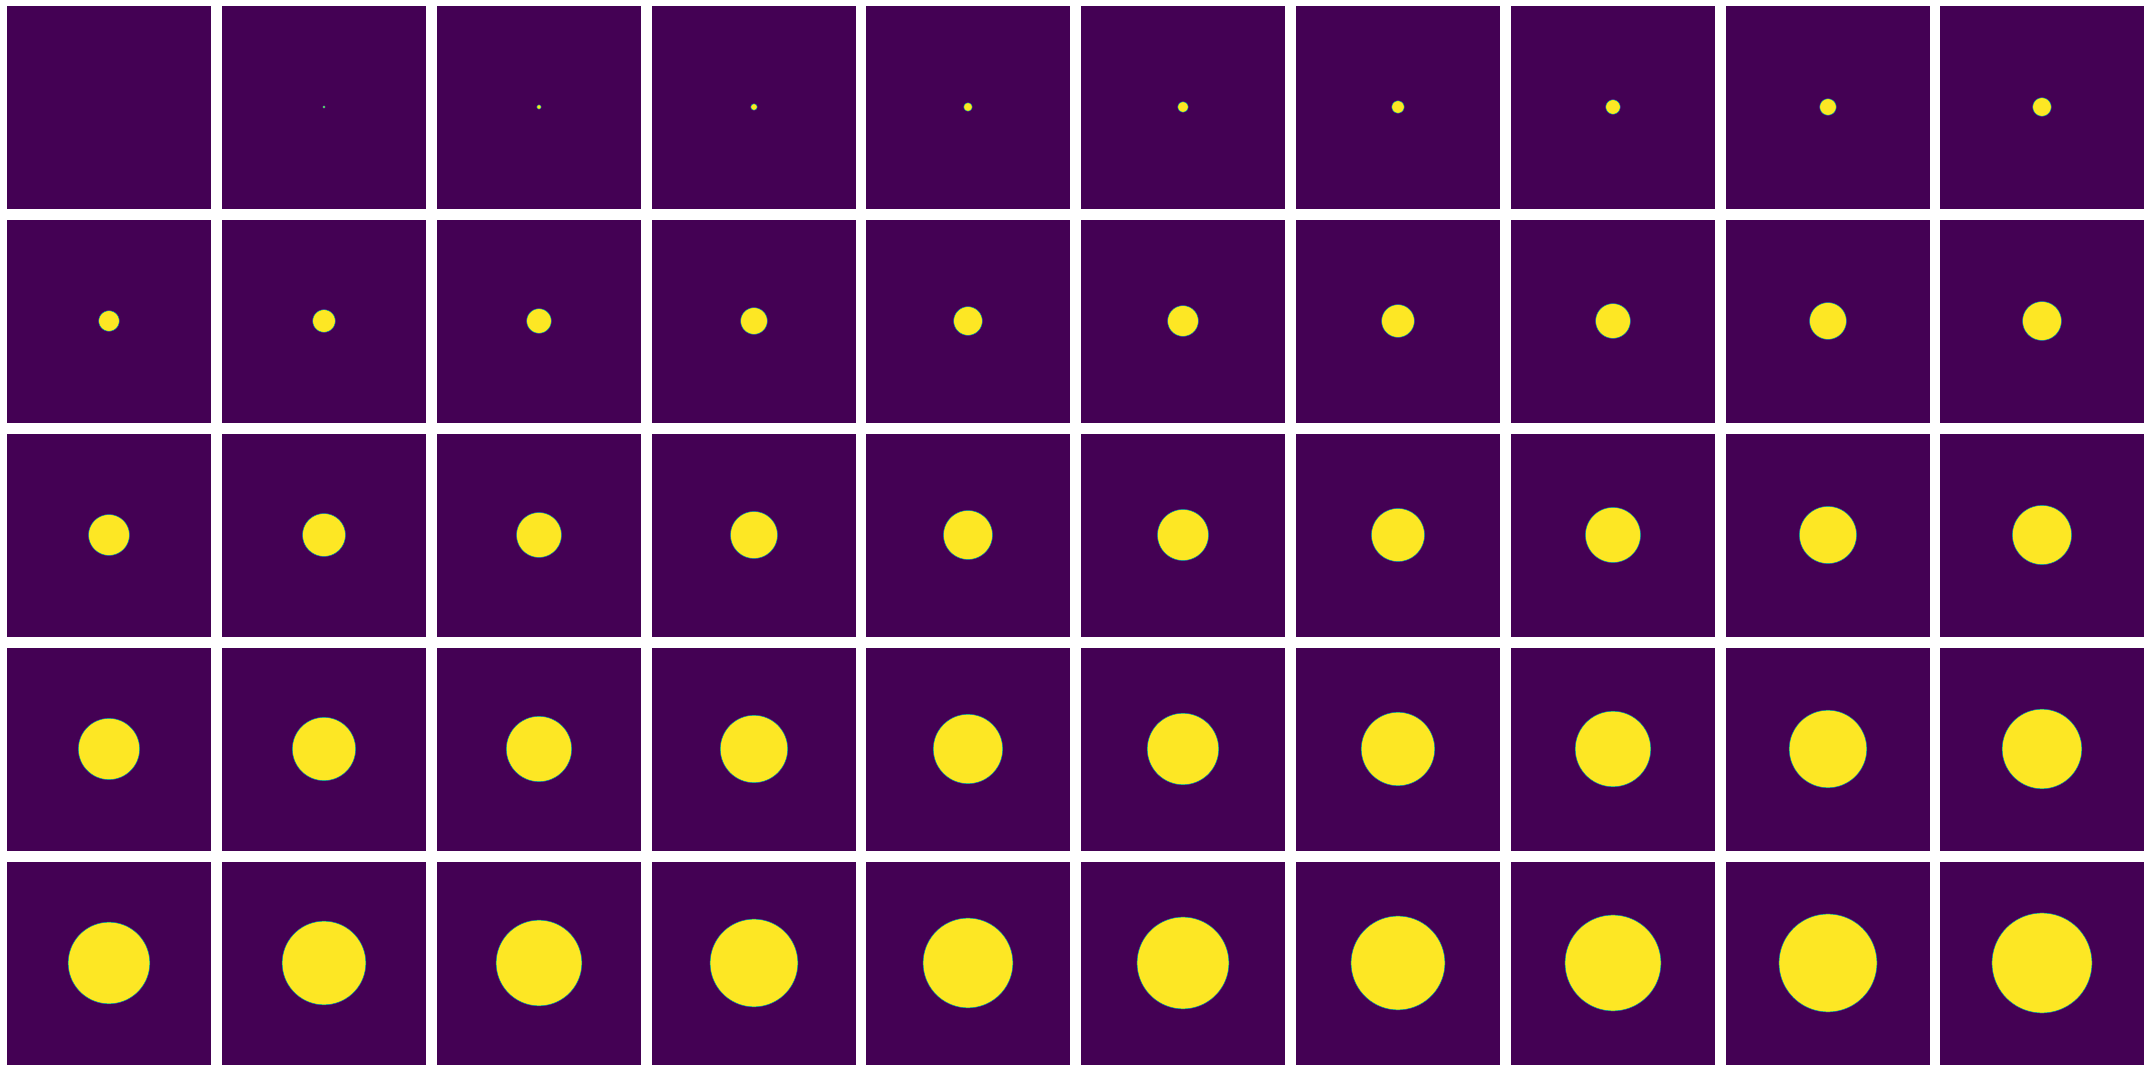

In [186]:
prf.plot_stims(SR_.stims_fill, interval=5)

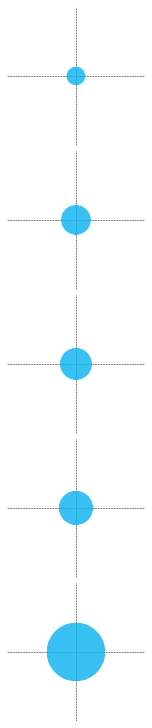

In [191]:
import matplotlib.patches as patches

sr_curve1 = SR_.make_sr_function(center_prf=True)
sr_curve2 = SR_.make_sr_function(center_prf=True, scale_factor=0.8)

fig = plt.figure(constrained_layout=True, figsize=(5,10))
gs01 = fig.add_gridspec(5,1)

use_stim_sizes = SR_.find_stim_sizes(sr_curve1, sr_curve2)
for ix,ii in enumerate(use_stim_sizes):

    # plot actual stimuli too
    ax = fig.add_subplot(gs01[ix])
    stim_ix = utils.find_nearest(SR_.stims_fill_sizes, ii)[0]
    cmap_blue = utils.make_binary_cm((8,178,240))

    plotting.LazyPRF(
        utils.resample2d(SR_.stims_fill[stim_ix],270), 
        [-5,5],
        ax=ax,
        cmap=cmap_blue,
        cross_color="k",
        edge_color=(0,0,0,0),
        alpha=0.8)

    # ax3.axvline(ii, color='k', lw=2, ymin=0.05, ymax=0.1)


    # ax.axvline(0, color='k', linestyle='dashed', lw=0.5, zorder=0)
    # ax.axhline(0, color='k', linestyle='dashed', lw=0.5, zorder=0)
    # ax.imshow(
    #     utils.resample2d(SR_.stims_fill[stim_ix],270), 
    #     extent=[-5,5]+[-5,5], cmap=cmap_blue,
    #     zorder=1)
    # ax.axis('off')
    # patch = patches.Circle((0,0), radius=[-5,5][-1], transform=ax.transData)
    # ax.set_clip_path(patch)

In [229]:
stim_rad = prf.radius(prf2)
x,y = np.where(run_prf == np.amax(run_prf))
center = (x[0],y[0])
print(center)


(245, 250)


In [230]:
prf_tmp = run_prf.copy()
prf_tmp[prf_tmp>0.5] = 1
mask = prf.create_circular_mask(
    prf_tmp.shape[0], 
    prf_tmp.shape[0], 
    radius=0.9*stim_rad,
    center=center)

prf4 = prf.create_circular_mask(
    prf_tmp.shape[0], 
    prf_tmp.shape[0], 
    radius=stim_rad,
    center=center)
    
mask.shape

(500, 500)

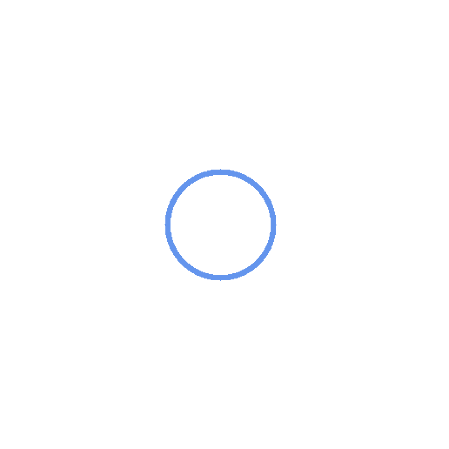

In [233]:
prf4[mask] = 0
plotting.LazyPRF(
    prf4, 
    [-5,5],
    cmap=cmap2,
    # cross_color="k",
    shrink_factor=0.9)
    # alpha=0.2)

In [226]:
np.where(run_prf == np.amax(run_prf))

(array([245]), array([250]))

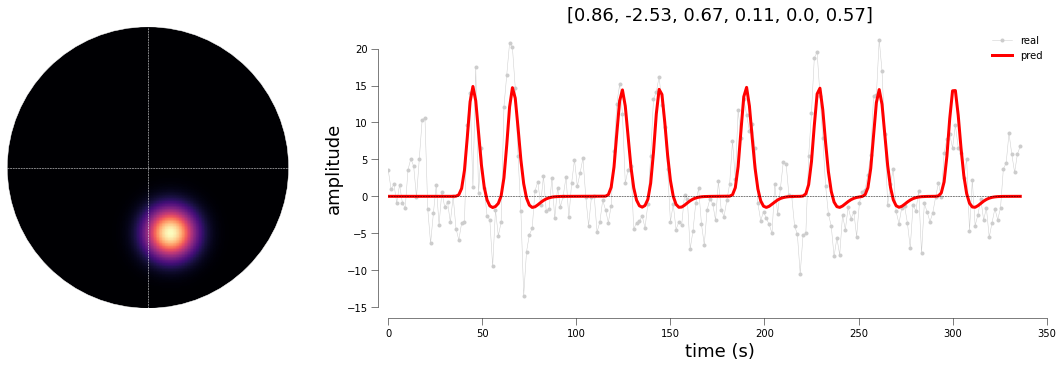

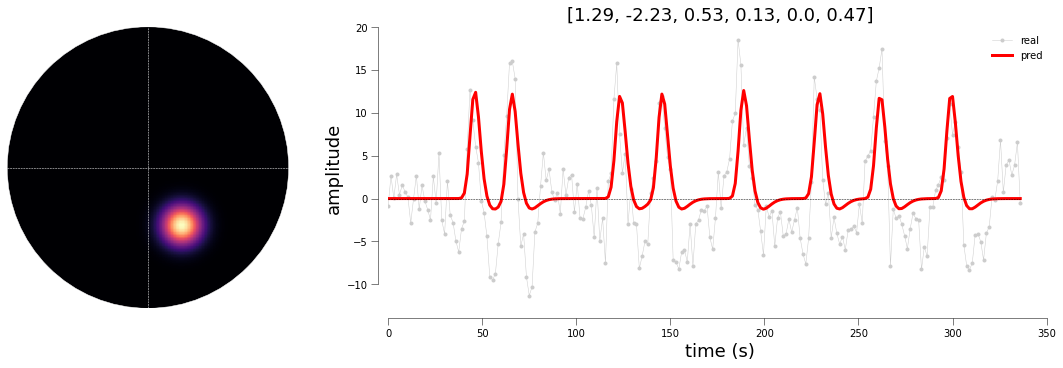

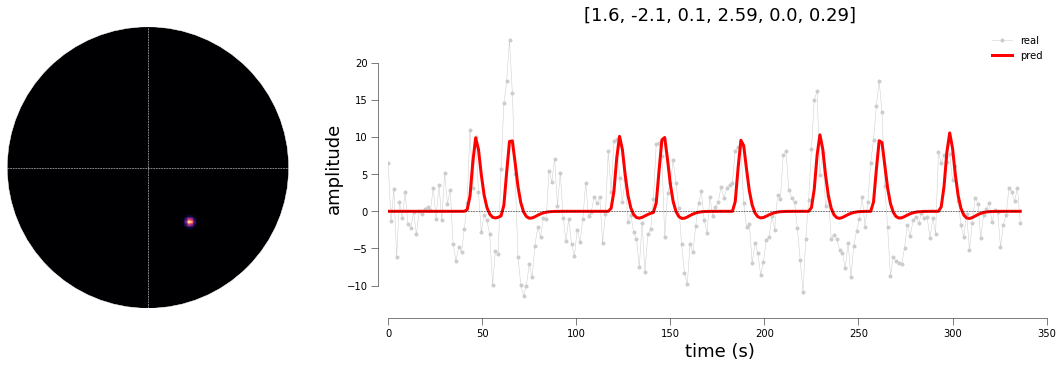

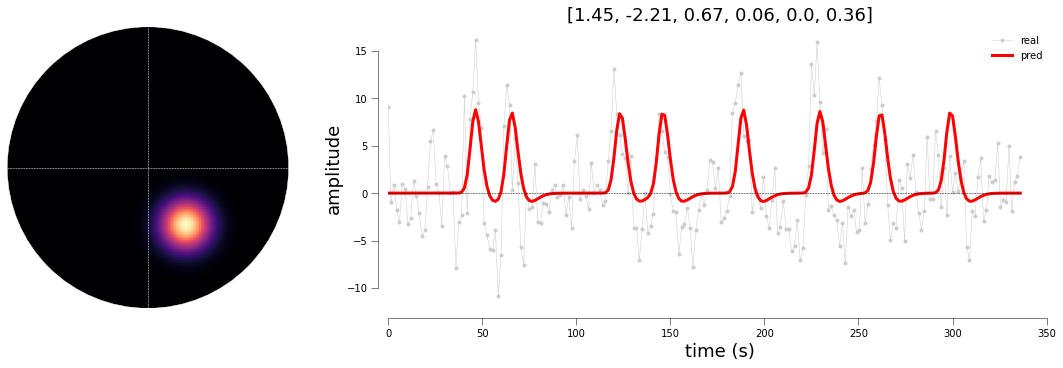

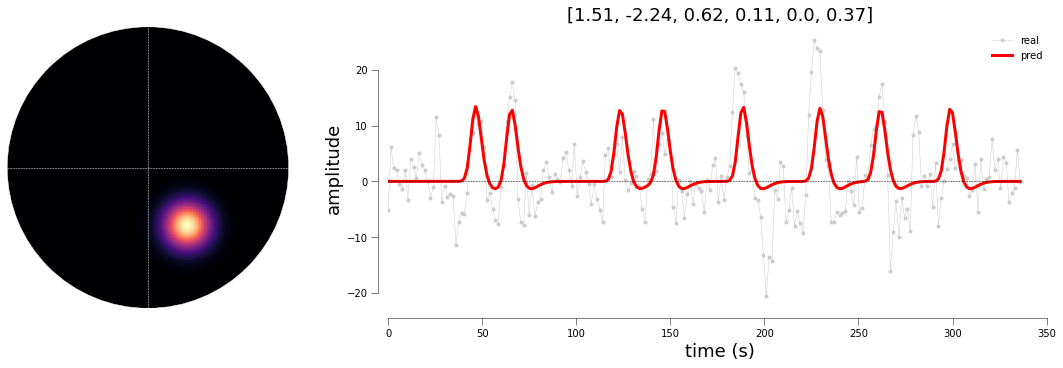

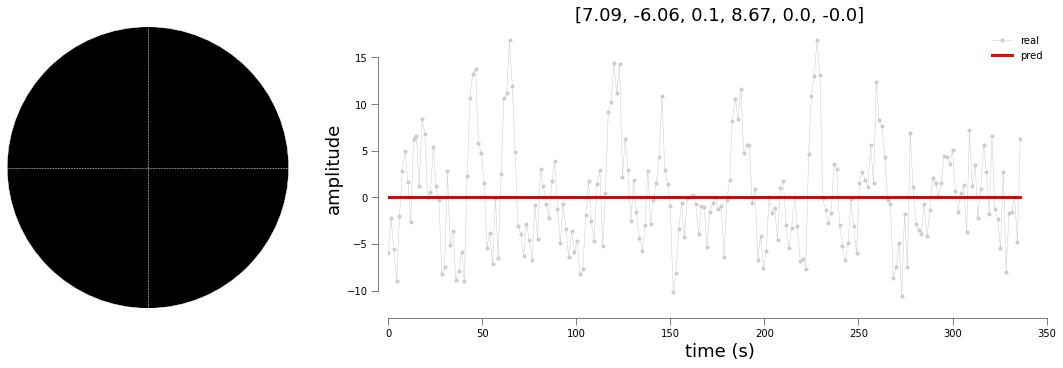

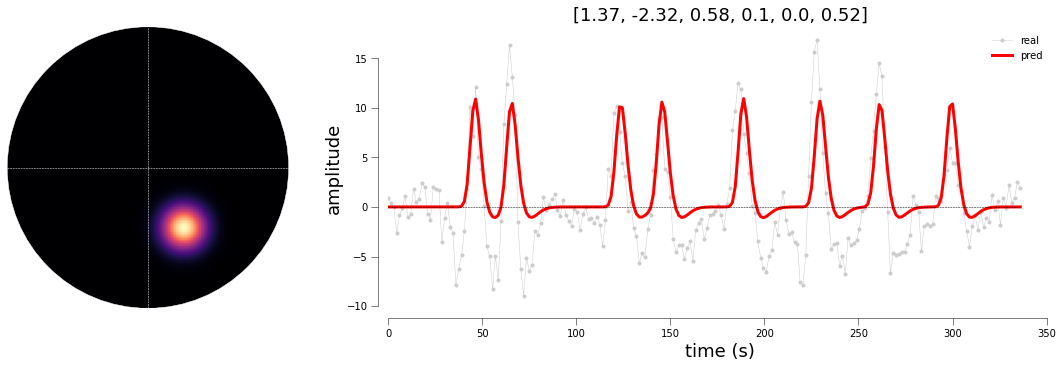

In [154]:
for key in list(fits.keys()):
    _,_,_,_ = fits[key].plot_vox(
        model="gauss",
        stage="iter",
        axis_type="time",
        title="pars"
    )